In [1]:
import pandas as pd
from mvdata import EquitiesData
import yfinance as yf

def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()
    actions.columns = ["Date", ticker + "_Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    # decision = []
    # previous_decision = ""
    
    # for value in actions[ticker + "_Signal"].values.tolist():
    #     if value == previous_decision:
    #         decision.append("Hold")
    #     else:
    #         decision.append(value)
    #         previous_decision = value
    
    # # actions[ticker + "_Signal"] = decision
    actions = actions.drop(["Date"],axis=1)

    return actions


# This is probably a trend following signal which we need to lookout for so hold this for later
df = EquitiesData("AAPL TSLA MSFT ANF").get_historical_data()["Adj Close"]
window = 50

rolling_mean = df.rolling(window=window).mean()
rolling_std = df.rolling(window=window).std()

buy_signal = df <= rolling_mean + rolling_std
sell_signal = df > rolling_mean - rolling_std

ticker_action = pd.DataFrame(df.index)

for tick in df.columns.tolist():
    ticker_action[tick + "_Signal"] = action_tickers(tick,buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

[*********************100%%**********************]  4 of 4 completed


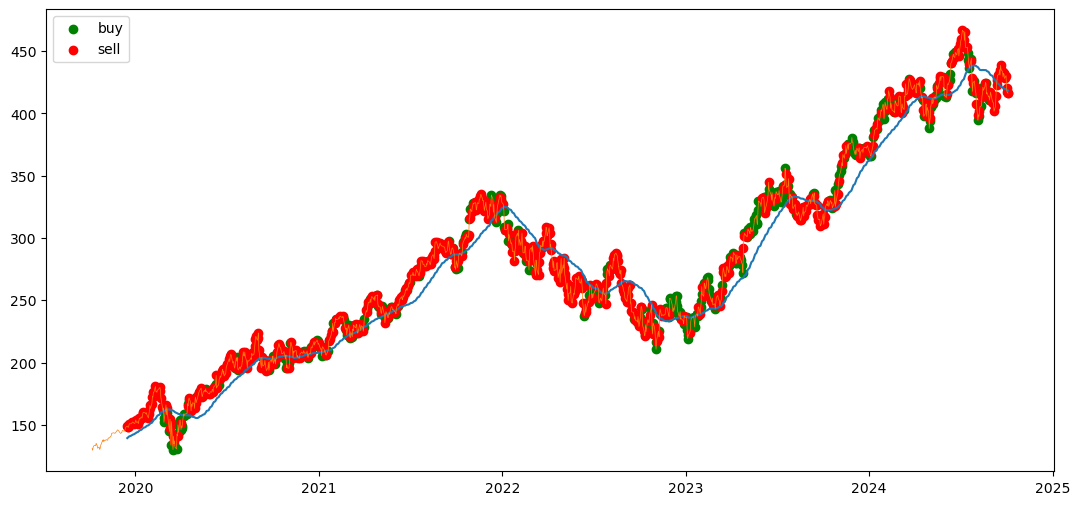

In [2]:
from matplotlib import pyplot as plt

figure, ax = plt.subplots(figsize=(13, 6))

plot_data = pd.concat([df,ticker_action],axis=1)

s = "MSFT"

plt.plot(rolling_mean[s])

buy = plot_data.loc[plot_data[s +"_Signal"] == "Buy", [s, s +"_Signal"]]
sell = plot_data.loc[plot_data[s +"_Signal"] == "Sell", [s, s +"_Signal"]]

plt.plot(plot_data[s],linewidth=.5)

ax.scatter(buy.index,buy[s],color="green",label="buy")
ax.scatter(sell.index,sell[s],color="red",label="sell")

plt.legend()
plt.show()

sellTailAction
0% [############################# ] 100% | ETA: 00:00:00Stat                 sellTailAction
-------------------  ----------------
Start                2019-10-06
End                  2024-10-04
Risk-free rate       0.00%

Total Return         155.74%
Daily Sharpe         0.67
Daily Sortino        1.11
CAGR                 20.67%
Max Drawdown         -51.90%
Calmar Ratio         0.40

MTD                  -0.15%
3m                   -7.01%
6m                   26.53%
YTD                  6.32%
1Y                   21.96%
3Y (ann.)            7.13%
5Y (ann.)            20.67%
10Y (ann.)           -
Since Incep. (ann.)  20.67%

Daily Sharpe         0.67
Daily Sortino        1.11
Daily Mean (ann.)    26.69%
Daily Vol (ann.)     39.67%
Daily Skew           -0.05
Daily Kurt           3.74
Best Day             14.76%
Worst Day            -14.83%

Monthly Sharpe       0.69
Monthly Sortino      1.58
Monthly Mean (ann.)  25.21%
Monthly Vol (ann.)   36.59%
Monthly Skew         0.56

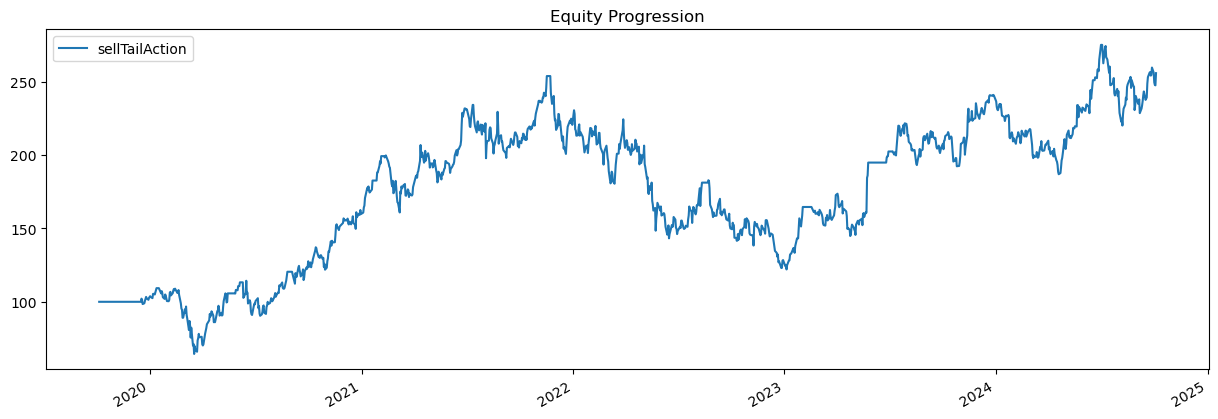

In [3]:
import bt

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(buy_signal),
                                        bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df,integer_positions=False, progress_bar=True)

res = bt.run(t2)
res.plot()
res.display()

<Axes: title={'center': 'Equity Progression'}>

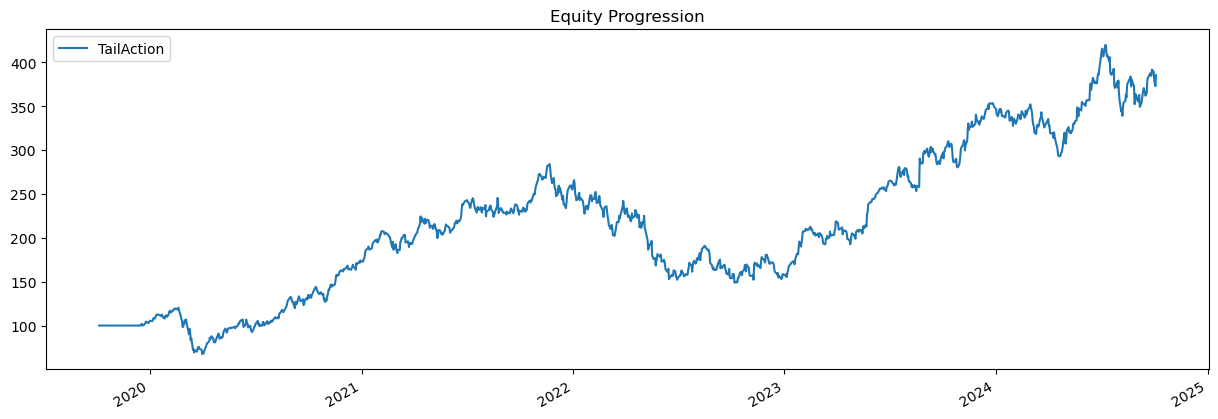

In [4]:
strat1 = bt.Strategy('buyTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t1 = bt.Backtest(strat1,df,integer_positions=False, progress_bar=True)

strat2 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(sell_signal),
                                        bt.algos.RunAfterDays(window),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t2 = bt.Backtest(strat2, df,integer_positions=False, progress_bar=True)

tests = [t1,t2]

combined_strat = bt.Strategy('TailAction', [bt.algos.SelectAll(),
                                            bt.algos.RunAfterDays(window),
                                            bt.algos.WeighEqually(),
                                            bt.algos.Rebalance()],
                                            children = [x.strategy for x in tests])

combined_test = bt.Backtest(
    combined_strat,
    df,
    integer_positions = False,
    progress_bar = False
)

res = bt.run(combined_test)

res.plot()

In [5]:
res.display()

Stat                 TailAction
-------------------  ------------
Start                2019-10-06
End                  2024-10-04
Risk-free rate       0.00%

Total Return         285.26%
Daily Sharpe         0.96
Daily Sortino        1.55
CAGR                 30.99%
Max Drawdown         -47.62%
Calmar Ratio         0.65

MTD                  -0.99%
3m                   -7.27%
6m                   20.41%
YTD                  10.06%
1Y                   29.10%
3Y (ann.)            18.76%
5Y (ann.)            30.99%
10Y (ann.)           -
Since Incep. (ann.)  30.99%

Daily Sharpe         0.96
Daily Sortino        1.55
Daily Mean (ann.)    32.98%
Daily Vol (ann.)     34.40%
Daily Skew           -0.35
Daily Kurt           4.93
Best Day             12.63%
Worst Day            -15.74%

Monthly Sharpe       0.93
Monthly Sortino      1.99
Monthly Mean (ann.)  33.52%
Monthly Vol (ann.)   36.00%
Monthly Skew         0.13
Monthly Kurt         0.55
Best Month           27.23%
Worst Month          -

In [25]:
# import json
# import requests
# import os
# import yfinance as yf

# criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

# tickers = list(criteria["Portfolio Weights"].keys())

# for stock_ex in criteria["Exchanges"]:
#     github_branch = "https://raw.githubusercontent.com/rreichel3/US-Stock-Symbols/main"
#     exchange =  "/" + stock_ex + "/" + stock_ex + "_full_tickers.json" 

#     url = github_branch + exchange # combining the repository dataset with the specific exchange

#     resp = requests.get(url)
#     data = json.loads(resp.text)

#     for i in range(len(data)):
#         ticker = data[i]

#         immediate_criteria = list(criteria["Immediate Criteria"].keys()) # ["lastsale", "volume", "marketCap"]
        
#         # important to note that since the list of tickers is massive, need to find any method to narrow scope

#         # Step 1: Check to see if anything is blank from the full json file or ticker already in portfolio
#         if ticker["symbol"] in tickers or any(ticker[checker] == "" for checker in immediate_criteria): 
#             continue

#         # numeric comparison
#         lastsale = float(ticker[immediate_criteria[0]][1:])
#         volume = float(ticker[immediate_criteria[1]])
#         marketCap = float(ticker[immediate_criteria[2]])

#         # Step 2: eliminate low cost stocks, less volume, and bound the marketcap due to portfolio size
#         check_1 = lastsale > criteria["Immediate Criteria"][immediate_criteria[0]] \
#             and volume > criteria["Immediate Criteria"][immediate_criteria[1]]
            
#         check_2 = marketCap <= criteria["Immediate Criteria"][immediate_criteria[2]]

#         if check_1 and check_2:
#             greater = criteria["Portfolio Criteria"]["Greater"]
#             less_than = criteria["Portfolio Criteria"]["Less Than"]

#             symbol = ticker["symbol"]

#             # list of metrics for criteria
#             metrics = list(greater.keys())
#             metrics.extend(list(less_than.keys()))

#             values = dict(filter(lambda item: item[0] in metrics, yf.Ticker(symbol).info.items()))
            
#             try:
#                 # Step 3: select tickers whick satisfy all of these conditions
#                 check_3 = all(values[metric] > x for metric,x in greater.items()) 
#                 check_4 = all(values[metric] < x for metric,x in less_than.items())
#                 if check_3 and check_4:
#                     tickers.append(symbol)

#             except KeyError:
#                 continue

# print(tickers)




    # def shortlist_tickers(self):
    #     tickers = RecommendTicker().get_all_tickers()
    #     new_tickers = []

    #     crit = list(Criteria().get_immediate_criteria().keys())

    #     for stock_ex in self.exchanges:
    #         data = tickers[stock_ex]

    #         ticker_data = []
    #         metric_data = {metric: [] for metric in crit}

    #         for tick_val in data:
    #             check_1 = tick_val["symbol"] in list(Basket().get_portfolio().keys())
    #             check_2 = any(tick_val[checker] == "" for checker in crit)

    #             if check_1 or check_2:
    #                 continue
                
    #             lastsale = float(tick_val[crit[0]][1:])
    #             volume = float(tick_val[crit[1]])
    #             marketCap = float(tick_val[crit[2]])

    #             ticker_data.append(tick_val["symbol"])
                
    #             # loop unrolling to save time here
    #             metric_data[crit[0]].append(lastsale)
    #             metric_data[crit[1]].append(volume)
    #             metric_data[crit[2]].append(marketCap)
                        
    #         metric_arrays = {metric: np.array(values) for metric, values in metric_data.items()}
            
    #         check_3 = np.ones(len(ticker_data), dtype=bool)
    #         check_4 = np.ones(len(ticker_data), dtype=bool)

    #         check_3 &= metric_arrays[crit[0]] > criteria["Immediate Criteria"][crit[0]]
    #         check_3 &= metric_arrays[crit[1]] > criteria["Immediate Criteria"][crit[1]]

    #         check_4 &= metric_arrays[crit[2]] < criteria["Immediate Criteria"][crit[2]]

    #         final_check = check_3 & check_4

    #         ticker_data = np.array(ticker_data)[final_check].tolist()

    #         new_tickers.extend(ticker_data)
        
    #     new_tickers = [tick.replace("/",".") for tick in new_tickers if "^" not in tick]

    #     return new_tickers



# criteria = json.loads(open(os.getcwd() + "\\criteria.json","r").read())

# class Criteria:
#     def __init__(self):
#         self.greater = criteria["Portfolio Criteria"]["Greater"]
#         self.less_than = criteria["Portfolio Criteria"]["Less Than"]
    
#     def get_immediate_criteria(self):
#         return criteria["Immediate Criteria"]
    
#     def get_greater_criteria(self):
#         return self.greater

#     def get_less_criteria(self):
#         return self.less_than
    
#     def get_metrics(self):
#         metrics = list(self.greater.keys())
#         metrics.extend(list(self.less_than.keys()))
#         return metrics

# yoy_dataset = pd.DataFrame()

        # if "yoy_value" in list(sub_data.columns):
        #     sub_data["yoy_value"] = sub_data["yoy_value"].str.replace("[,%)]","",regex=True)
        #     sub_data["yoy_value"] = sub_data["yoy_value"].str.replace("(","-")
            
        #     date1 = sub_data["date"].drop_duplicates().tolist()[0]

        #     sub_data.loc[sub_data["date"] == date1, "yoy_value"] = 0
        #     sub_data["yoy_value"] = sub_data["yoy_value"].replace("-", np.nan)

        #     sub_data["yoy_value"] = sub_data["yoy_value"].astype(float)/100

        #     yoy_dataset = pd.concat([yoy_dataset,sub_data[["account","date","yoy_value"]]])

# yoy_values = pd.DataFrame(index=yoy_dataset["account"].drop_duplicates().tolist(),
#                           columns=yoy_dataset["date"].drop_duplicates().tolist())

    # yoy_values[date] = yoy_dataset.loc[values_dataset["date"] == date, "yoy_value"].values
    # yoy_values[date] = yoy_values[date].fillna(0) 

# yoy_dataset = yoy_dataset.reset_index(drop=True)



# class Basket:
#     def __init__(self):
#         pass
        
#     def get_portfolio(self):
#         requires proper connectivity to the Interactive Brokers site first
#         will have to be from a json file and we will have to not query too often from there but just enough
#         pass
    
#     def update_portfolio(self, key: str, value: float):
#         values = list(self.portfolio.values())
#         if value <= 0:
#             raise ValueError("To add to portfolio, the ticker weight must be greater than 0")
#         elif sum(values) + value > 1:
#             raise ValueError("Max for current portfolio is " + str(1-sum(values)) + " based on current portfolio.")            
#         elif key in list(self.portfolio.keys()):
#             self.portfolio.update({key: value})
#         else:
#             self.portfolio[key] = value
            
#     def remove_ticker(self, key: str):
#         try:
#             del self.portfolio[key]
#         except KeyError:
#             print("This ticker was not in the portfolio.")




# only applicable after I use the code for retrieving market data and refer to EquitiesData class
# class PortfolioAnalytics:
#     def __init__(self):
#         self.portfolio = Basket().get_portfolio()
#         pass
    
#     def portfolio_data(self):
#         tick = ""

#         for ticker in list(self.portfolio.keys()):
#             tick += (ticker + " ")

#         return EquitiesData(tick).get_historical_data()

#     def correlation_matrix(self):
#         df = self.portfolio_data().corr()
#         df = df.where(np.triu(np.ones(df.shape)).astype(np.bool_))

#         return df
                             
#     def portfolio_volatility(self):
#         Q = PortfolioAnalytics().portfolio_data().cov()
#         w = np.array(list(self.portfolio.values()))

#         var = np.matmul(np.matmul(w.T,Q),w)

#         return np.sqrt(var)
    
#     def portfolio_beta(self):
#         beta = 0

#         for tick,weight in self.portfolio.items():
#             try:
#                 beta += (weight*yf.Ticker(tick).info["beta"])
#             except:
#                 continue
        
#         return beta

# def public_comps(tick: str): pass


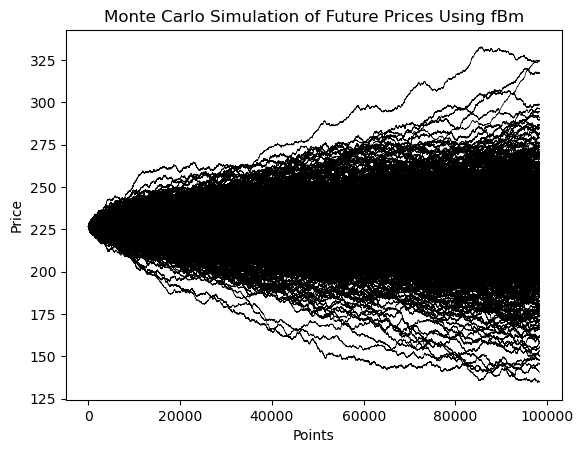

In [24]:
import matplotlib.pyplot as plt
from stochastic.processes.noise import FractionalGaussianNoise
import yfinance as yf
import numpy as np
import pandas as pd

df = yf.download('AAPL', start="2019-09-26", progress=False)
num_days = 252

num_simulations = 1000
simulation = np.zeros((num_days*390+1, num_simulations))

start = df["Adj Close"].values.tolist()[-1]

hursts = []

for i in range(num_simulations):
  H = np.random.normal(loc=.53,scale=.07)
  hursts.append(H)
  fgn = FractionalGaussianNoise(hurst=H,t=num_days)
  sim = fgn._sample_fractional_gaussian_noise(num_days*390)
  sim = sim.cumsum()
  sim = np.insert(sim, [0], 0)

  simulation[:, i] += sim

  ruin = np.where(sim < start*-1)[0].tolist()
  if len(ruin) >= 1:
    simulation[ruin[0]:,i] = start*-1
  
simulation = pd.DataFrame(simulation) + start

for i in range(num_simulations):
    plt.plot(simulation[i], lw=0.5,color="black")


plt.title(f"Monte Carlo Simulation of Future Prices Using fBm")
plt.xlabel("Points")
plt.ylabel("Price")
plt.show()

In [25]:
simulation

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,...,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003,226.800003
1,226.806212,226.874256,226.810670,226.807899,226.749477,226.808980,226.808639,226.844797,226.807313,226.932716,...,226.784742,226.801135,226.792713,226.816517,226.836496,226.876361,226.820910,226.725846,226.658108,226.788790
2,226.787886,226.848679,226.805914,226.811917,226.757124,226.801535,226.786300,226.846717,226.830024,226.938710,...,226.766658,226.812525,226.802309,226.837622,226.861770,226.776681,226.834027,226.748448,226.771945,226.794230
3,226.782039,226.786936,226.787622,226.853480,226.820138,226.758223,226.741370,226.860631,226.822438,226.936189,...,226.774043,226.895547,226.781424,226.851104,226.877556,226.590704,226.875504,226.746056,226.823976,226.782956
4,226.744979,226.802748,226.792249,226.852129,226.884920,226.723751,226.762002,226.798935,226.825507,226.951185,...,226.801448,226.966003,226.768268,226.879992,226.876358,226.794617,226.900962,226.742221,226.735904,226.761445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98276,286.480909,230.068249,210.486785,243.522537,233.431946,223.776410,194.354321,244.857020,182.520328,250.231624,...,284.993316,214.768856,193.616000,249.722508,242.853514,224.837044,241.240349,220.956307,225.587621,208.377195
98277,286.485785,229.991563,210.456743,243.391468,233.538909,223.729046,194.315471,244.814496,182.480769,250.262281,...,284.996251,214.762873,193.633048,249.747351,242.850300,224.994154,241.233688,220.913818,225.539463,208.377331
98278,286.490198,229.930917,210.473463,243.495690,233.565191,223.631617,194.302338,244.858241,182.497798,250.289250,...,284.949027,214.710099,193.656991,249.787811,242.854363,224.969077,241.233072,220.873072,225.586877,208.362967
98279,286.497468,229.939919,210.469420,243.508833,233.546791,223.609403,194.283742,244.867849,182.438517,250.275678,...,284.929694,214.731702,193.682072,249.810749,242.852508,225.010385,241.210091,220.870618,225.760310,208.352216


In [26]:
pd.Series([start - np.percentile(simulation.iloc[i],.01) for i in range(1,len(simulation))])

0         0.194391
1         0.325297
2         0.351041
3         0.628260
4         0.604635
           ...    
98275    91.291046
98276    91.310385
98277    91.284095
98278    91.268118
98279    91.268478
Length: 98280, dtype: float64

226.8000030517578
-0.12942133573016779
197.4472437131932


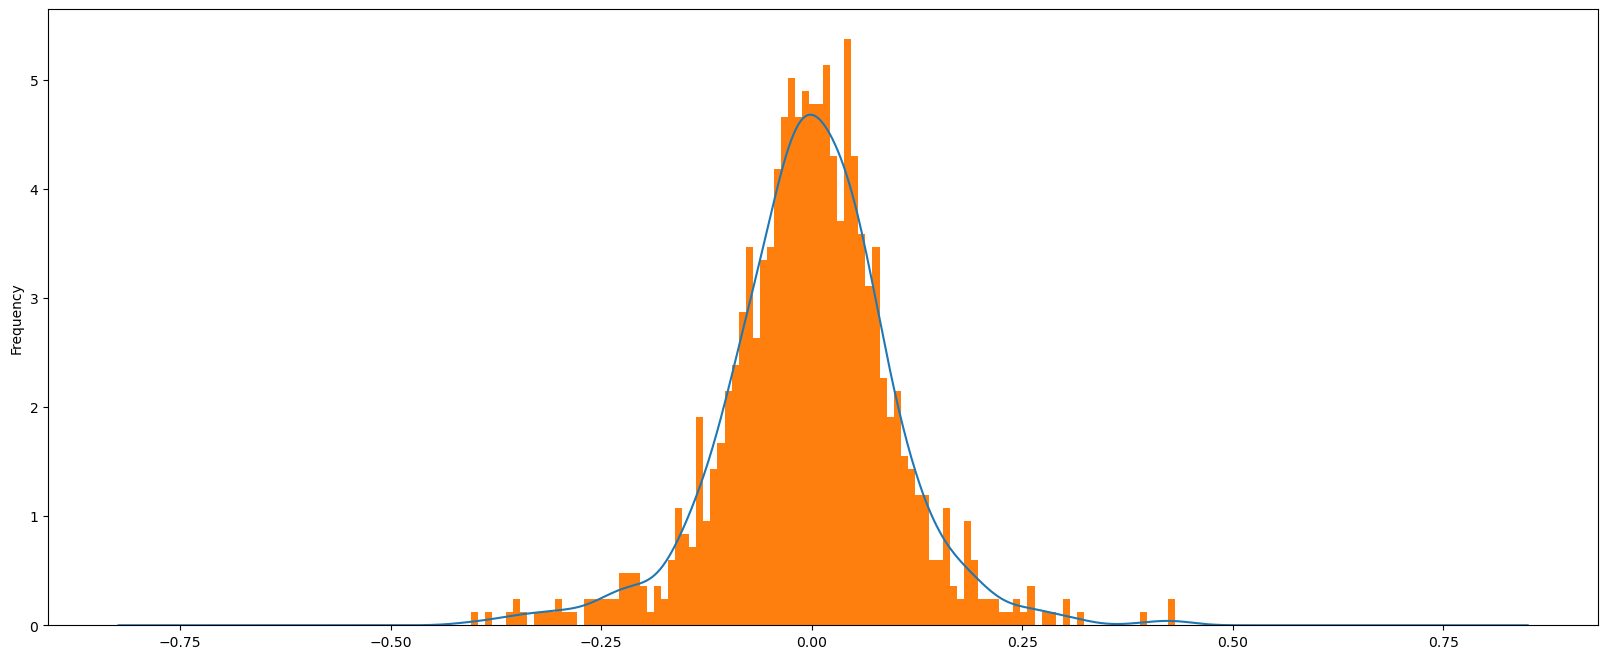

In [34]:
fig, ax = plt.subplots()

ret = (simulation.iloc[len(simulation)-1]/start) - 1

print(start)
print(ret.skew())
print(start*(1+ret.skew()))

ret.plot(kind="kde",figsize=(20,8))
ret.plot(kind="hist",bins=100,density=True)
# plt.xticks(np.arange(-1,max(ret),step=.4))
plt.show()

In [30]:
sorted(ret.values.tolist())

[-0.40483471008243954,
 -0.38064670459204586,
 -0.3584337778332157,
 -0.34878443792113967,
 -0.3485802145519903,
 -0.3384565012859394,
 -0.32313120691697705,
 -0.3142863437509479,
 -0.3061288704312478,
 -0.3022282613656242,
 -0.2996447670291158,
 -0.2888639889231839,
 -0.2853674597498673,
 -0.26838720762083523,
 -0.26528066308091114,
 -0.26018739667907553,
 -0.254360897910336,
 -0.24787380997032615,
 -0.24606253436963144,
 -0.24364634930018692,
 -0.24356628776627576,
 -0.23478479627205495,
 -0.23205761013910242,
 -0.2274895658913424,
 -0.2269745306042118,
 -0.22686934002402404,
 -0.22082523598040715,
 -0.21554839356994582,
 -0.21521296624300934,
 -0.21427252650792705,
 -0.2132800845827999,
 -0.2088042245657975,
 -0.20857262608049665,
 -0.20600372178605608,
 -0.20574832902870188,
 -0.20371881552286764,
 -0.20103775399623203,
 -0.19577582764419532,
 -0.19339984830848211,
 -0.18403652857108044,
 -0.1822300518830432,
 -0.18010798636097614,
 -0.17636709463114297,
 -0.17397155567172695,
 -0.

In [367]:
import yfinance as yf
import datetime as dt

a = []

for i in range(30):
    day = dt.datetime.today() - pd.Timedelta(days=i)

    is_weekday = dt.datetime.isoweekday(day)
    if is_weekday == 6 or is_weekday == 7:
        continue

    start = day.strftime("%Y-%m-%d")

    if is_weekday == 5:
        end = (day + pd.Timedelta(days=3)).strftime("%Y-%m-%d")
    else:
        end = (day + pd.Timedelta(days=1)).strftime("%Y-%m-%d")

    df = yf.download("SNOW", start=start, end=end, interval="1m",progress=False)["Adj Close"]
    
    a.append([start,df.skew(),df.kurtosis()])

pd.DataFrame(reversed(a),columns=["Date", "Skew", "Kurtosis"])

,Date,Skew,Kurtosis
0,2024-07-24,0.809778,-0.754612
1,2024-07-25,-0.658695,-0.874560
2,2024-07-26,0.336752,0.583664
3,2024-07-29,-0.589748,-0.682283
4,2024-07-30,1.144737,1.381376
5,2024-07-31,-0.378248,-0.842448
6,2024-08-01,1.176682,0.636115
7,2024-08-02,-0.679031,-0.447422
8,2024-08-05,-0.333589,0.343150
9,2024-08-06,-0.820835,0.365668


In [ ]:
import yfinance as yf
import pandas as pd
import requests
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt

querystring = {
    "symbol": "aapl",
    "data_type": "eps",
    "period_type": "annual"
}

headers = {
    "x-rapidapi-key": ,
    "x-rapidapi-host": "seeking-alpha.p.rapidapi.com"
}

url = "https://" + headers["x-rapidapi-host"] + "/symbols/get-estimates"

response = requests.get(url, headers=headers, params=querystring).json()

data = response["data"]

df = pd.concat([pd.DataFrame(data[i]["attributes"],index=[0]) 
                for i in range(len(data))],axis=0).reset_index(drop=True)

In [5]:
# df = df.astype(float)

df

,slug,actual,period_end_date,quarter,year,fwd_pe,consensus
0,aapl,6.11,2022-09-30,4,2022,None,6.10809
1,aapl,6.13,2023-09-30,4,2023,None,6.07131
2,aapl,None,2024-09-30,4,2024,None,6.68847
3,aapl,None,2025-09-30,4,2025,None,7.41252
4,aapl,None,2026-09-30,4,2026,None,8.38551


In [10]:
import yfinance as yf
import pandas as pd
import requests
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt

querystring2 = {
    "symbol": "aapl",
    "data_type": "eps",
    "period_type": "quarterly"
}

headers = {
    "x-rapidapi-key": ,
    "x-rapidapi-host": "seeking-alpha.p.rapidapi.com"
}

url = "https://" + headers["x-rapidapi-host"] + "/symbols/get-estimates"

response2 = requests.get(url, headers=headers, params=querystring2).json()

data2 = response2["data"]

df2 = pd.concat([pd.DataFrame(data2[i]["attributes"],index=[0]) 
                for i in range(len(data2))],axis=0).reset_index(drop=True)

df2.index = df2["period_end_date"].values

# df2 = df2[["actual","consensus"]]

In [11]:
# df2 = df2.astype(float)

df2

,slug,actual,period_end_date,quarter,year,fwd_pe,consensus
2023-09-30,aapl,1.46,2023-09-30,4,2023,None,1.39284
2023-12-31,aapl,2.18,2023-12-31,1,2024,None,2.10313
2024-03-31,aapl,1.53,2024-03-31,2,2024,None,1.50804
2024-06-30,aapl,1.4,2024-06-30,3,2024,None,1.34150
2024-09-30,aapl,None,2024-09-30,4,2024,None,1.59910
2024-12-31,aapl,None,2024-12-31,1,2025,None,2.37941


In [9]:
pd.DataFrame(index=pd.date_range(start="2022-09-30",end="2026-09-30",freq="Q-MAR"))

""
2022-09-30
2022-12-31
2023-03-31
2023-06-30
2023-09-30
2023-12-31
2024-03-31
2024-06-30
2024-09-30
2024-12-31


[*********************100%%**********************]  1 of 1 completed

Correlation between Trading Volume and Stock Price: -0.22


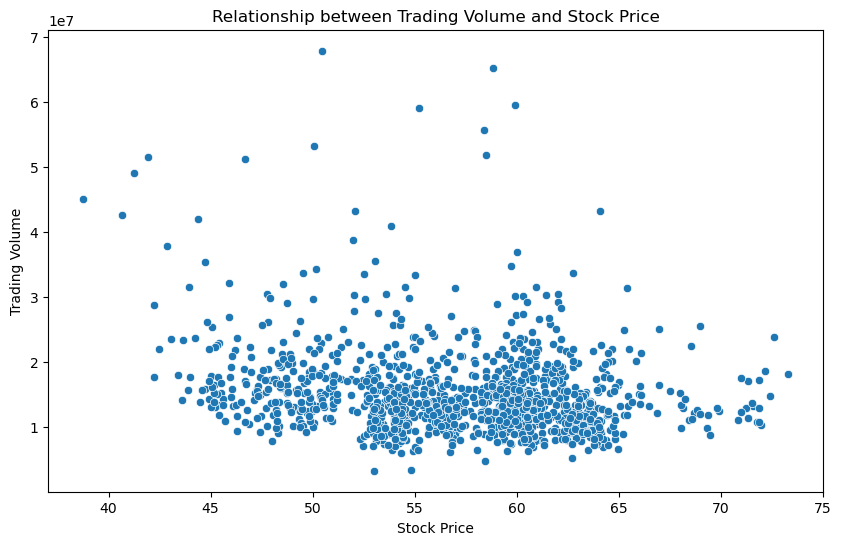

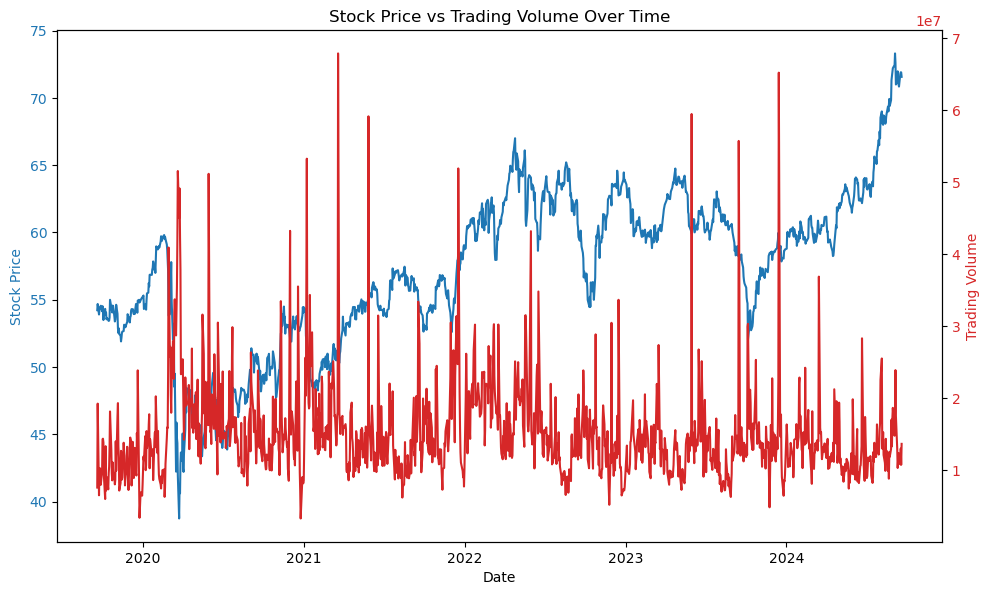

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Sample data (replace with actual stock data)
# Assuming you have 'Date', 'Volume', and 'Close' (stock price) in your dataset
df = yf.download("KO",start="2019-09-19")

# Correlation between Volume and Close (stock price)
correlation = df['Volume'].corr(df['Open'])
print(f"Correlation between Trading Volume and Stock Price: {correlation:.2f}")

# Plotting the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Open'], y=df['Volume'])
plt.title('Relationship between Trading Volume and Stock Price')
plt.xlabel('Stock Price')
plt.ylabel('Trading Volume')
plt.show()

# Plot time series for Volume and Stock Price to visualize the trend
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Stock Price', color='tab:blue')
ax1.plot(df.index, df['Open'], color='tab:blue', label='Stock Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Trading Volume', color='tab:red')
ax2.plot(df.index, df['Volume'], color='tab:red', label='Trading Volume')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Stock Price vs Trading Volume Over Time')
plt.show()


<Axes: >

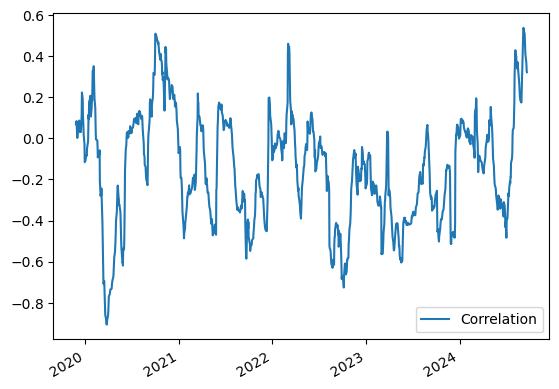

In [62]:
import numpy as np
corr = pd.DataFrame(df["Volume"].rolling(window=50).corr(df["Open"]),
                    index=df.index.tolist(),columns=["Correlation"]).dropna()

corr.plot()

In [24]:
import pandas as pd

pd.read_html("https://www.pnw.coop/fccp-commodity-symbols-17667")[4]


,0,1,2
0,Symbol,Name,Grouping
1,C,Corn,Grains and Oilseeds
2,ZC,Corn (E),Grains and Oilseeds
3,O,Oats,Grains and Oilseeds
4,ZO,Oats (E),Grains and Oilseeds
5,W,Wheat,Grains and Oilseeds
6,ZW,Wheat (E),Grains and Oilseeds
7,S,Soybeans,Grains and Oilseeds
8,ZS,Soybeans (E),Grains and Oilseeds
9,RR,Rough Rice,Grains and Oilseeds


In [110]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import yfinance as yf

# Sample data (replace with actual stock data)
# Assume we have 'Date', 'Open', 'Volume', and 'Close' columns
df = yf.download("TSLA",start="2019-09-23")
df["Volume_dt"] = df["Volume"].pct_change().fillna(0)
df["NextOpen"] = df["Open"].shift(-1).fillna(df["Close"].iloc[len(df)-1])

# Independent variables (Open, Volume)
X = df[['Close', 'Volume_dt']]

# Add a constant to the independent variables (for the intercept)
X = sm.add_constant(X)

# Dependent variable (Close)
y = df['NextOpen']

# Initialize TimeSeriesSplit
n_splits = 5  # You can choose the number of splits based on the data size
tscv = TimeSeriesSplit(n_splits=5)

# List to store evaluation metrics for each split
volume_coef = 0
price = []

# Perform regression on each split

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the model using statsmodels for each split
    model = LinearRegression()

    model.fit(X_train,y_train)

    # Print the model summary for the current split
    # print(f"\nModel Summary for Split {split_number}:\n")
    # print(model.summary())
    
    # Make predictions using the test data
    y_pred = model.predict(X_test)

    volume_coef += model.coef_[2]/5

    results = {
        "True Values": y_test.values,
        "Predicted Values": y_pred
    }

    results = pd.DataFrame(results,index=y_test.index)

    price.append(results)


price = pd.concat(price)

test_start = price.index[0]
val = len(df) - len(price)

price = pd.concat([pd.DataFrame(index=df.index[:val]),price])

price["True Values"].iloc[:val] = df["NextOpen"].iloc[:val]
price["Predicted Values"].iloc[:val] = df["NextOpen"].iloc[:val]

correlation = []

for end in range(len(price),0,-1):
    vol_window = df["Volume_dt"].iloc[end-50:end]
    price_window = price["Predicted Values"].iloc[end-50:end]

    correlation.insert(0,vol_window.corr(price_window,method="spearman"))

price["Correlation"] = correlation

price = price.loc[price.index >= test_start]

df.loc[df.index >= test_start, "Adj Close"]



# price = pd.concat([df["NextOpen"].iloc[:len(df)-len(price)],price],axis=0)

# price["True Values"].iloc[:len(df)-len(price)] = price[0].iloc[:len(df)-len(price)]
# price["Predicted Values"].iloc[:len(df)-len(price)] = price[0].iloc[:len(df)-len(price)]

# price
# price = price.drop([0],axis=1)

# price

# df.loc[df.index >= test_start]
    
    # Evaluate the model
    # intercept_list += (model.coef_[0]/5)
    # open_coef_list += (model.coef_[1]/5)
    # volume_coef_list += (model.params[2]/5)

# Visualize the actual vs predicted values for the last split
# avg_intercept = sum(intercept_list) / len(intercept_list)
# avg_open_coef = sum(open_coef_list) / len(open_coef_list)
# avg_volume_coef = sum(volume_coef_list) / len(volume_coef_list)
# print(f"Averaged Model Equation: Close Price = {intercept_list:.2f} + {open_coef_list:.4f} * Open Price + {volume_coef_list:.8f} * Volume_dt")        

[*********************100%%**********************]  1 of 1 completed


Date
2020-07-30     99.166000
2020-07-31     95.384003
2020-08-03     99.000000
2020-08-04     99.133331
2020-08-05     99.001335
                 ...    
2024-09-25    257.019989
2024-09-26    254.220001
2024-09-27    260.459991
2024-09-30    261.630005
2024-10-01    258.019989
Name: Adj Close, Length: 1050, dtype: float64

In [111]:
print("Averaged Model Equation: Close Price = 0.33 + 1.0017 * Open Price + -0.08707217 * Volume_dt")

Averaged Model Equation: Close Price = 0.33 + 1.0017 * Open Price + -0.08707217 * Volume_dt


[*********************100%%**********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:               NextOpen   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.861e+04
Date:                Tue, 24 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:25:50   Log-Likelihood:                -143.08
No. Observations:                 682   AIC:                             292.2
Df Residuals:                     679   BIC:                             305.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1091      0.032      3.362      0.0

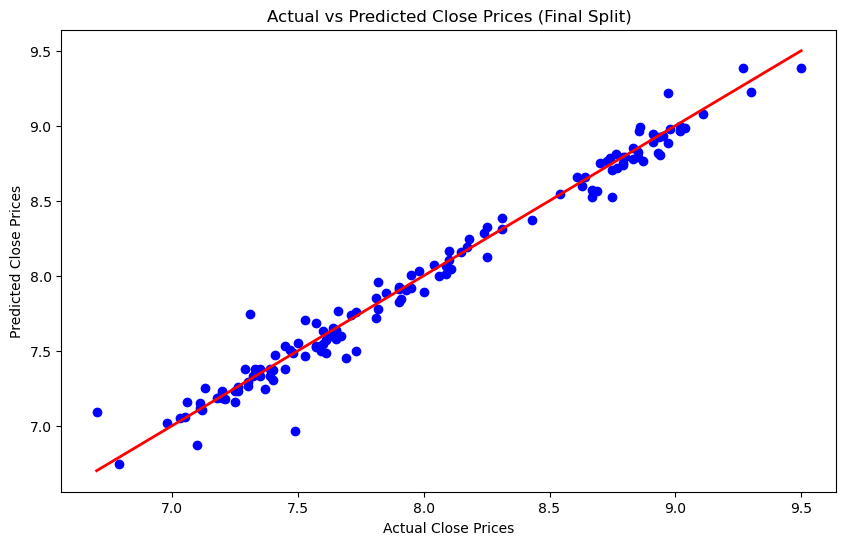

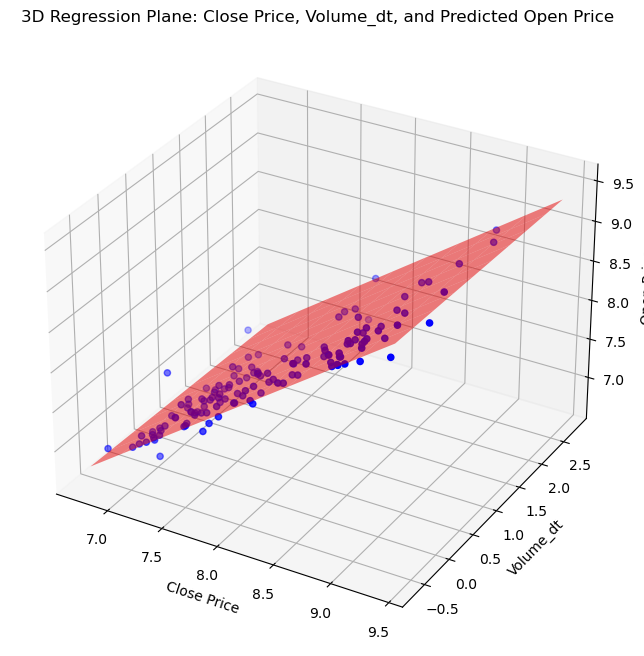

In [35]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import yfinance as yf

# Sample data (replace with actual stock data)
df = yf.download("YMM",start="2019-09-23")
df["Volume_dt"] = df["Volume"].pct_change().fillna(0)
df["NextOpen"] = df["Open"].shift(-1).fillna(df["Close"].iloc[len(df)-1])

# Independent variables (Open, Volume)
X = df[['Close', 'Volume_dt']]

# Add a constant to the independent variables (for the intercept)
X = sm.add_constant(X)

# Dependent variable (Close)
y = df['NextOpen']

# Initialize TimeSeriesSplit
n_splits = 5  # You can choose the number of splits based on the data size
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform regression on the final split for the summary
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Fit the model using statsmodels for detailed summary stats
model = sm.OLS(y_train, X_train).fit()

# Print the model summary (stats)
print(model.summary())

# Coefficients (Model equation)
intercept = model.params[0]
close_coef = model.params[1]
volume_coef = model.params[2]

print(f"Model Equation: Open Price = {intercept:.2f} + {close_coef:.4f} * Close Price + {volume_coef:.4f} * Volume_dt")

# Make predictions using the test data
y_pred = model.predict(X_test)

# 2D Plot: Actual vs Predicted Close Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # 45-degree line
plt.title('Actual vs Predicted Close Prices (Final Split)')
plt.xlabel('Actual Close Prices')
plt.ylabel('Predicted Close Prices')
plt.show()

# 3D Plot: Regression Plane with Open, Volume, and Predicted Close Price
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Grid data for plotting the plane
open_range = np.linspace(X_test['Close'].min(), X_test['Close'].max(), 10)
volume_range = np.linspace(X_test['Volume_dt'].min(), X_test['Volume_dt'].max(), 10)
open_grid, volume_grid = np.meshgrid(open_range, volume_range)
predicted_grid = intercept + close_coef * open_grid + volume_coef * volume_grid

# Scatter plot of actual test data
ax.scatter(X_test['Close'], X_test['Volume_dt'], y_test, color='blue', label='Actual Close')

# Surface plot of the regression plane
ax.plot_surface(open_grid, volume_grid, predicted_grid, color='red', alpha=0.5, label='Regression Plane')

ax.set_xlabel('Close Price')
ax.set_ylabel('Volume_dt')
ax.set_zlabel('Open Price')
plt.title('3D Regression Plane: Close Price, Volume_dt, and Predicted Open Price')
plt.show()


In [233]:
df["Volume_dt"].corr(df["Open"],method="spearman")

0.012086128785870268

<Axes: ylabel='Density'>

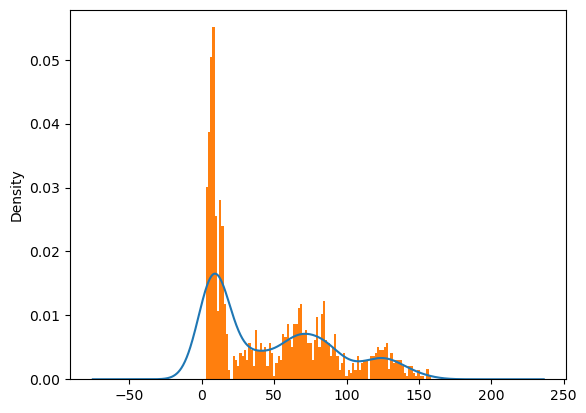

In [234]:
df["Open"].plot(kind="kde")
df["Open"].hist(density=True,grid=False,bins=100)

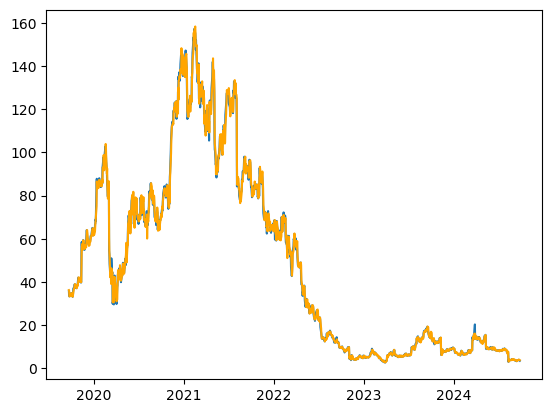

In [235]:
plt.plot(intercept + close_coef * df["Close"] + volume_coef * df["Volume_dt"])
plt.plot(df["Open"],color="orange")

In [238]:
correlation = []

for i in range(len(df),0,-1):
    correlation.insert(0,df["Volume_dt"].iloc[i-50:i].corr(df["NextOpen"].iloc[i-50:i],method="spearman"))

pd.DataFrame(correlation,index=df.index)

# pd.DataFrame(correlation,index=df.index,columns=["corr"]).dropna().plot()
# plt.ylim(bottom=-1,top=1)
# plt.show()

,0
Date,
2019-12-02,-0.052294
2019-12-03,-0.034142
2019-12-04,0.003650
2019-12-05,0.000864
2019-12-06,-0.055512
...,...
2024-09-17,0.044183
2024-09-18,0.039717
2024-09-19,0.036499


In [ ]:
import requests
import pandas as pd

main_ids = [32991,10,32992,1,32455,32263,3008,33060]
querystring = {
    "category_id": 1,
    "api_key": "dc0d23814216e498df77d56c353faca9",
    "file_type": "json",
    "limit": 1000,
    "sort_order": "asc"
}

headers = {
    'cache-control': "no-cache"
}

response = requests.get("https://api.stlouisfed.org/fred/category/series", headers=headers, params=querystring)

pd.DataFrame(response.json()["seriess"])["title"].head(n=5).tolist()

In [10]:
import mvdata as mvD
import pandas as pd
import numpy as np
from mvmodels import weighted_cost

inital = ["Total Revenues", "EBIT", "Income Tax Expense", "Depreciation & Amortization, Total", 
          "Capital Expenditure", "Change In Net Working Capital", "Cash And Equivalents", 
          "Total Common Shares Outstanding"]

ticker = mvD.EquitiesData("SBUX")

financials = pd.concat([ticker.get_financials("income-statement"),
                        ticker.get_financials("balance-sheet"),
                        ticker.get_financials("cash-flow-statement")],axis=0)

In [11]:
financials = financials.drop(["TTM", "Last Report"],axis=1)

financials.columns = [int(val[4:]) for val in financials.columns.tolist()]
wacc = weighted_cost("ANF",financials)

start = max(financials.columns.tolist())

if financials.index.values.tolist()[0] == start:
    financials = financials.iloc[::-1]

financials = financials[~financials.index.duplicated(keep="first")].T 

cash = financials.loc[financials.index == start,"Cash And Equivalents"].values.tolist()[0]
shares = financials.loc[financials.index == start,"Total Common Shares Outstanding"].values.tolist()[0]

debt = 0
for fin in ["Short-Term Borrowings", "Current Portion of Lease Obligations", 
            "Long-Term Debt", "Capital Leases"]:
    if fin in financials.columns.tolist():
        val = financials.loc[financials.index == start, fin].values.tolist()[0]
        debt += val

financials = financials[inital[:len(inital)-2]]

[*********************100%%**********************]  5 of 5 completed


In [12]:
growth_rates = pd.DataFrame()
growth_rates.index = financials.index.values-start

growth_rates["Total Revenues"] = (financials["Total Revenues"]/financials["Total Revenues"].shift(1)).values-1
growth_rates["EBIT"] = (financials["EBIT"]/financials["Total Revenues"]).values
growth_rates["Income Tax Expense"] = (financials["Income Tax Expense"]/financials["EBIT"]).values

for col in inital[3:6]:
    growth_rates[col] = (financials[col]/financials["Total Revenues"]).values

growth_rates = growth_rates.T
growth_rates[-4] = np.nan

In [13]:
values = financials.T

for i,k in zip(range(0,5,1), range(start,start+5,1)):
    history = growth_rates.columns.tolist()[i]
    years = [j for j in range(history,i+1,1)]
    growth_rates[i+1] = growth_rates[years].mean(axis=1)
    values[k+1] = values[k] * (1+growth_rates[i+1])

    val_calc = values[k+1].loc[values[k+1].index.isin(inital[:3])].values
    growth_calc = growth_rates[i+1].loc[growth_rates[i+1].index.isin(inital[:3])].values
    next_ebit = val_calc[0] * growth_calc[1]
    next_tax = next_ebit * growth_calc[2]
    values[k+1].loc[values[k+1].index == "EBIT"] = next_ebit
    values[k+1].loc[values[k+1].index == "Income Tax Expense"] = next_tax

cols1 = values.columns.tolist()
cols1 = np.array(cols1[cols1.index(start+1):])

values = values.T
values["EBIT"] = values["EBIT"].shift(1)            
values["Income Tax Expense"] = values["Income Tax Expense"].shift(1)            
values = values.loc[values.index.isin(cols1)]

values

,Total Revenues,EBIT,Income Tax Expense,"Depreciation & Amortization, Total",Capital Expenditure,Change In Net Working Capital
2024,39106.655238,5526.100000,1277.200000,1524.301133,-2196.134755,-739.676829
2025,42510.214810,5095.781582,1070.596288,1602.078151,-2066.767167,-745.803995
2026,47909.119991,5539.281443,1163.773222,1679.692828,-1946.746662,-740.298646
2027,52952.421324,6839.501644,1519.389610,1759.724115,-1830.780625,-741.524413
2028,58479.046669,7357.986733,1599.469820,1843.647286,-1720.816311,-740.108035


In [14]:
growth_rates

,-4,-3,-2,-1,0,1,2,3,4,5
Total Revenues,NaN,-0.112816,0.235675,0.109760,0.115512,0.087033,0.087033,0.127003,0.105268,0.104370
EBIT,NaN,0.068029,0.161786,0.137797,0.153607,0.130305,0.130305,0.142760,0.138955,0.139186
Income Tax Expense,NaN,0.149822,0.246001,0.213434,0.231121,0.210095,0.210095,0.222149,0.217379,0.218168
"Depreciation & Amortization, Total",NaN,0.063917,0.052446,0.047423,0.040313,0.051025,0.051025,0.048446,0.047646,0.047691
Capital Expenditure,NaN,-0.063084,-0.050584,-0.057094,-0.064866,-0.058907,-0.058907,-0.058072,-0.059569,-0.060064
Change In Net Working Capital,NaN,0.086610,-0.052569,0.019485,-0.020392,0.008284,0.008284,-0.007382,0.001656,-0.001910


In [15]:
unlevered_fcf = values[inital[1]]-values[inital[2]]+values[inital[3]]-values[inital[4]]-values[inital[5]]
unlevered_fcf = unlevered_fcf.values

unlevered_fcf

array([ 8709.01271599,  8439.83460775,  8742.24635651,  9652.14118673,
       10063.08854624])

In [16]:
cols2 = growth_rates.columns.tolist()
cols2 = np.array(cols2[cols2.index(1):])

tgvs = [.025+(i*.005) for i in range(-2,5,1)]
waccs = [0.089+(i*.004) for i in range(-2,5,1)]

fair_values = np.zeros((len(tgvs),len(waccs)))

for i in range(len(tgvs)):
    for j in range(len(waccs)):
        pv_fcf = unlevered_fcf/((1+waccs[j])**cols2)

        tv = (unlevered_fcf[-1]*(1+waccs[j]))/(waccs[j]-tgvs[i])
        pv_tv = tv/((1+waccs[j])**cols2[-1])

        enterprise_value = pv_tv + pv_fcf.sum()
        fair_value = (enterprise_value+cash-debt)/shares

        fair_values[i,j] += round(fair_value,2)

fair_values = pd.DataFrame(fair_values,index=tgvs,columns=waccs)

fair_values

,0.081,0.085,0.089,0.093,0.097,0.101,0.105
0.015,112.44,105.16,98.67,92.83,87.56,82.77,78.40
0.020,120.45,112.15,104.80,98.25,92.37,87.07,82.26
0.025,129.89,120.29,111.89,104.47,97.86,91.94,86.61
0.030,141.18,129.92,120.18,111.67,104.16,97.49,91.53
0.035,154.92,141.48,130.01,120.11,111.48,103.89,97.15
0.040,172.02,155.60,141.84,130.15,120.09,111.33,103.65
0.045,193.87,173.25,156.37,142.28,130.34,120.10,111.22


In [97]:
import mvdata as mvD
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit

s = "AAPL"

df = yf.download(s)

# df["Volume_dt"] = np.log(df["Volume"]/df["Volume"].shift(1))
# df["NextOpen"] = df["Open"].shift(-1).fillna(df["Close"].iloc[len(df)-1])


df.iloc[100:205].tail(n=50)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-07-27,0.111607,0.112165,0.111607,0.111607,0.086038,17337600
1981-07-28,0.108259,0.108259,0.107701,0.107701,0.083026,22848000
1981-07-29,0.106585,0.106585,0.106027,0.106027,0.081736,15500800
1981-07-30,0.109933,0.111049,0.109933,0.109933,0.084747,9900800
1981-07-31,0.111607,0.112165,0.111607,0.111607,0.086038,10953600
1981-08-03,0.111607,0.111607,0.110491,0.110491,0.085177,12432000
1981-08-04,0.112165,0.112723,0.112165,0.112165,0.086468,31673600
1981-08-05,0.115513,0.116071,0.115513,0.115513,0.089049,17494400
1981-08-06,0.113281,0.113281,0.112723,0.112723,0.086898,10528000


In [ ]:

X = df[["Close","Volume_dt"]]
y = df["NextOpen"]

n_splits = (df.index[-1] - df.index[0]) // pd.Timedelta(days=365)
tscv = TimeSeriesSplit(n_splits=n_splits)

volume_coef = 0
price = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = LinearRegression().fit(X_train,y_train)

    y_pred = model.predict(X_test)

    volume_coef += model.coef_[1]/n_splits

    results = {
        "True Values": y_test.values,
        "Predicted Values": y_pred
    }

    results = pd.DataFrame(results,index=y_test.index)

    price.append(results)
    
price = pd.concat(price)
test_start = price.index[0]
val = len(df) - len(price)

price = pd.concat([pd.DataFrame(index=df.index[:val]),price])

price["True Values"].iloc[:val] = y.iloc[:val]
price["Predicted Values"].iloc[:val] = y.iloc[:val]

correlation = []
corr_window = 50

for end in range(len(price),0,-1):
    vol_window = df["Volume_dt"].iloc[end-corr_window:end]
    price_window = price["Predicted Values"].iloc[end-corr_window:end]
    correlation.insert(0,vol_window.corr(price_window,method="spearman"))

price["Correlation"] = correlation

price = price.loc[price.index >= test_start]
adj_close = pd.DataFrame(df.loc[df.index >= test_start, "Adj Close"])
adj_close.columns = [s]

sell_signal = pd.DataFrame(price["Correlation"] < volume_coef)
sell_signal.columns = [s]

if volume_coef < 0:
    volume_coef = 0

buy_signal = pd.DataFrame(price["Correlation"] >= volume_coef)
buy_signal.columns = [s]

In [80]:
vol_price = pd.DataFrame(price.index)

vol_price[s + "_Signal"] = action_tickers(s,buy_signal,sell_signal)

date = vol_price.pop("Date")
vol_price = vol_price.set_index(date)

vol_price

,PLUG_Signal
Date,
2000-11-29,Buy
2000-11-30,Hold
2000-12-01,Hold
2000-12-04,Hold
2000-12-05,Hold
...,...
2024-10-01,Buy
2024-10-02,Buy
2024-10-03,Buy


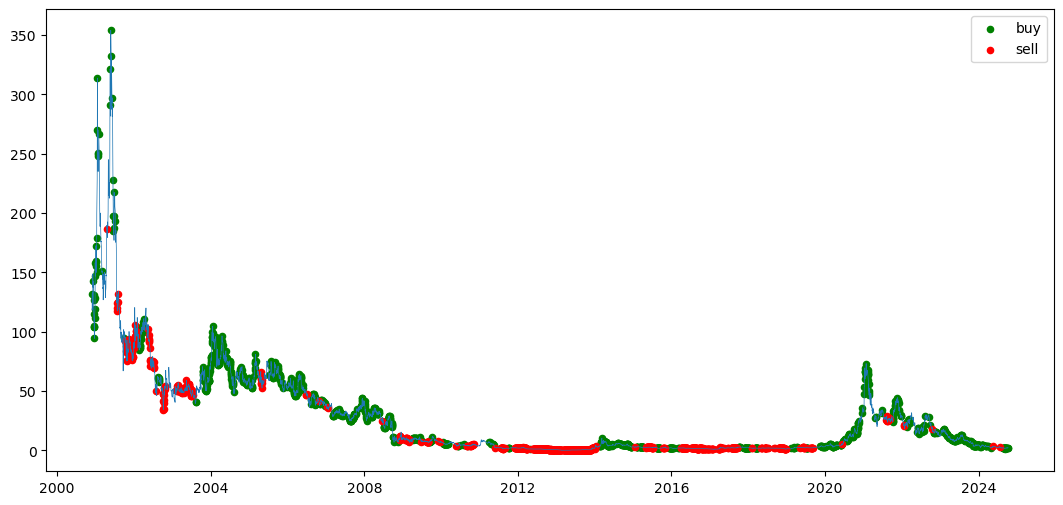

In [81]:
from matplotlib import pyplot as plt

figure, ax = plt.subplots(figsize=(13, 6))

plot_data = pd.concat([adj_close,vol_price],axis=1)

buy = plot_data.loc[plot_data[s +"_Signal"] == "Buy"]
sell = plot_data.loc[plot_data[s +"_Signal"] == "Sell"]

plt.plot(plot_data[s],linewidth=.5)

ax.scatter(buy.index,buy[s],color="green",label="buy",s=20)
ax.scatter(sell.index,sell[s],color="red",label="sell",s=20)

plt.legend()
plt.show()

sellTailAction
0% [############################# ] 100% | ETA: 00:00:00Stat                 sellTailAction
-------------------  ----------------
Start                2000-11-28
End                  2024-10-07
Risk-free rate       0.00%

Total Return         -97.46%
Daily Sharpe         -0.13
Daily Sortino        -0.19
CAGR                 -14.26%
Max Drawdown         -98.67%
Calmar Ratio         -0.14

MTD                  4.37%
3m                   -8.77%
6m                   -9.15%
YTD                  -45.66%
1Y                   -62.93%
3Y (ann.)            -24.25%
5Y (ann.)            -18.33%
10Y (ann.)           -16.73%
Since Incep. (ann.)  -14.26%

Daily Sharpe         -0.13
Daily Sortino        -0.19
Daily Mean (ann.)    -5.57%
Daily Vol (ann.)     44.23%
Daily Skew           0.74
Daily Kurt           47.37
Best Day             49.03%
Worst Day            -41.51%

Monthly Sharpe       -0.24
Monthly Sortino      -0.38
Monthly Mean (ann.)  -8.59%
Monthly Vol (ann.)   35.37%
Month

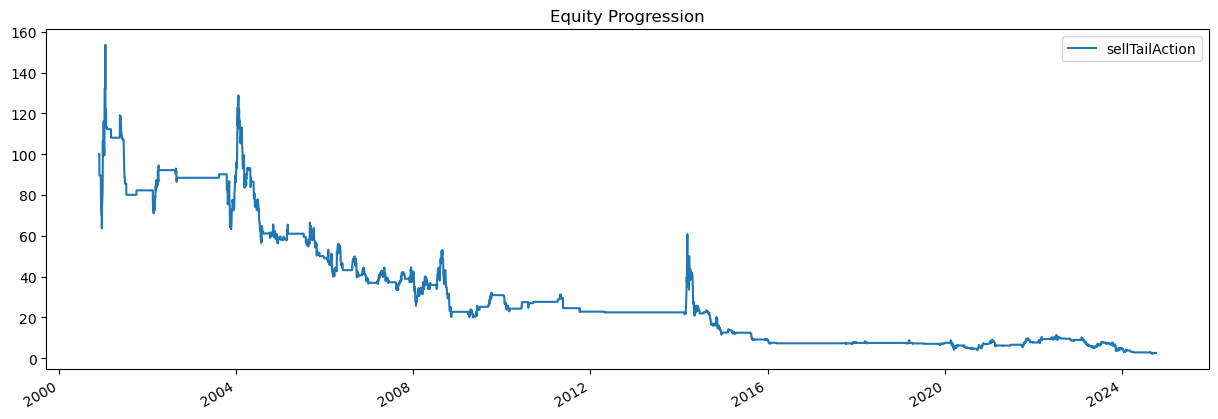

In [82]:
import bt

strat3 = bt.Strategy('sellTailAction', [bt.algos.SelectWhere(buy_signal),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])

# now we create the Backtest
t3 = bt.Backtest(strat3,pd.DataFrame(adj_close),integer_positions=False, progress_bar=True)

res = bt.run(t3)
res.plot()
res.display()

In [ ]:
df = yf.download("SBUX", start="2019-10-03")

df["day_range"] = df["High"]-df["Low"]
df["ibs_indicator"] = (df["Close"]-df["Low"])/df["day_range"]

df["day_range"] = df["day_range"].rolling(window=25).mean()
df["ibs_25"] = df["ibs_indicator"].rolling(window=25).mean()
df["lower_band"] = df["High"].rolling(window=10).mean()-(2.5*df["day_range"])

df = df.dropna()
df["lower_band"] = np.log(df["lower_band"]/df["lower_band"].shift(1)).fillna(0)

df["spy_close"] = yf.download("SPY", start=df.index[0])["Close"]
df["spy_close"] = np.log(df["spy_close"]/df["spy_close"].shift(1)).fillna(0)

buy_signal = (df["spy_close"] < df["lower_band"]) & (df["ibs_indicator"] < df["ibs_25"])
sell_signal = df["spy_close"] > np.log(df["High"].shift(1)/df["High"].shift(2))